# Football AI

---

[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/roboflow/sports)
[![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/camera-calibration-sports-computer-vision/)
[![YouTube](https://badges.aleen42.com/src/youtube.svg)](https://www.youtube.com/watch?v=aBVGKoNZQUw)

Let's build a Football AI system to dig deeper into match stats! We'll use computer vision and machine learning to track players, determine which team is which, and even calculate stuff like ball possession and speed. This tutorial is perfect if you want to get hands-on with sports analytics and see how AI can take your football analysis to the next level.

![football AI diagram](https://media.roboflow.com/notebooks/examples/football-ai-diagram.png)

## Before you start

### Configure your API keys

- Open your [`HuggingFace Settings`](https://huggingface.co/settings) page. Click `Access Tokens` then `New Token` to generate new token.
- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑).
    - Store HuggingFace Access Token under the name `HF_TOKEN`.
    - Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

### Select the runtime

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Sun Dec 15 16:45:49 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8              13W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Install dependencjes

**Note:** Let's install the `inference-gpu` library, which will be used to efficiently run our object detection and keypoint detection models on GPUs. `inference-gpu` utilizes the `onnxruntime-gpu` library internally for optimal performance. We'll install a specific version of `onnxruntime-gpu` to guarantee compatibility with the CUDA 12 environment in Google Colab.

In [2]:
!pip install -q gdown inference-gpu
!pip install -q onnxruntime-gpu==1.18.0 --index-url https://aiinfra.pkgs.visualstudio.com/PublicPackages/_packaging/onnxruntime-cuda-12/pypi/simple/

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.7/105.7 kB 4.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 888.7/888.7 kB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 68.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 72.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 891.9/891.9 kB 59.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.0/64.0 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 774.7/774.7 kB 56.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 7.9 MB/s et

**Note:** Let's install the sports repository directly from GitHub. The sports repository contains a variety of football-related utilities that we'll use along the way.

In [3]:
!pip install -q git+https://github.com/roboflow/sports.git

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 5.5 MB/s eta 0:00:00


**Note:** Let's make sure we have the latest features in the supervision library by installing version `0.23.0` or higher.

In [4]:
!pip uninstall -y supervision && pip install -q supervision>=0.23.0

Found existing installation: supervision 0.25.1
Uninstalling supervision-0.25.1:
  Successfully uninstalled supervision-0.25.1


**Note:** Let's download a few sample videos from the [DFL - Bundesliga Data Shootout](https://www.kaggle.com/competitions/dfl-bundesliga-data-shootout) Kaggle competition using gdown.



In [5]:
!gdown -O "0bfacc_0.mp4" "https://drive.google.com/uc?id=12TqauVZ9tLAv8kWxTTBFWtgt2hNQ4_ZF"
!gdown -O "2e57b9_0.mp4" "https://drive.google.com/uc?id=19PGw55V8aA6GZu5-Aac5_9mCy3fNxmEf"
!gdown -O "08fd33_0.mp4" "https://drive.google.com/uc?id=1OG8K6wqUw9t7lp9ms1M48DxRhwTYciK-"
!gdown -O "573e61_0.mp4" "https://drive.google.com/uc?id=1yYPKuXbHsCxqjA9G-S6aeR2Kcnos8RPU"
!gdown -O "121364_0.mp4" "https://drive.google.com/uc?id=1vVwjW1dE1drIdd4ZSILfbCGPD4weoNiu"

Downloading...
From: https://drive.google.com/uc?id=12TqauVZ9tLAv8kWxTTBFWtgt2hNQ4_ZF
To: /content/0bfacc_0.mp4
100% 19.9M/19.9M [00:00<00:00, 88.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=19PGw55V8aA6GZu5-Aac5_9mCy3fNxmEf
To: /content/2e57b9_0.mp4
100% 21.1M/21.1M [00:00<00:00, 75.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1OG8K6wqUw9t7lp9ms1M48DxRhwTYciK-
To: /content/08fd33_0.mp4
100% 19.9M/19.9M [00:00<00:00, 19.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1yYPKuXbHsCxqjA9G-S6aeR2Kcnos8RPU
To: /content/573e61_0.mp4
100% 18.9M/18.9M [00:00<00:00, 81.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1vVwjW1dE1drIdd4ZSILfbCGPD4weoNiu
To: /content/121364_0.mp4
100% 17.2M/17.2M [00:00<00:00, 32.6MB/s]


In [6]:
import os
os.environ["ONNXRUNTIME_EXECUTION_PROVIDERS"] = "[CUDAExecutionProvider]"

## ball, player, goalkeeper and referee detection

In [7]:
from inference import get_model
from google.colab import userdata

ROBOFLOW_API_KEY = userdata.get('ROBOFLOW_API_KEY')
PLAYER_DETECTION_MODEL_ID = "football-players-detection-3zvbc/11"
PLAYER_DETECTION_MODEL = get_model(model_id=PLAYER_DETECTION_MODEL_ID, api_key=ROBOFLOW_API_KEY)

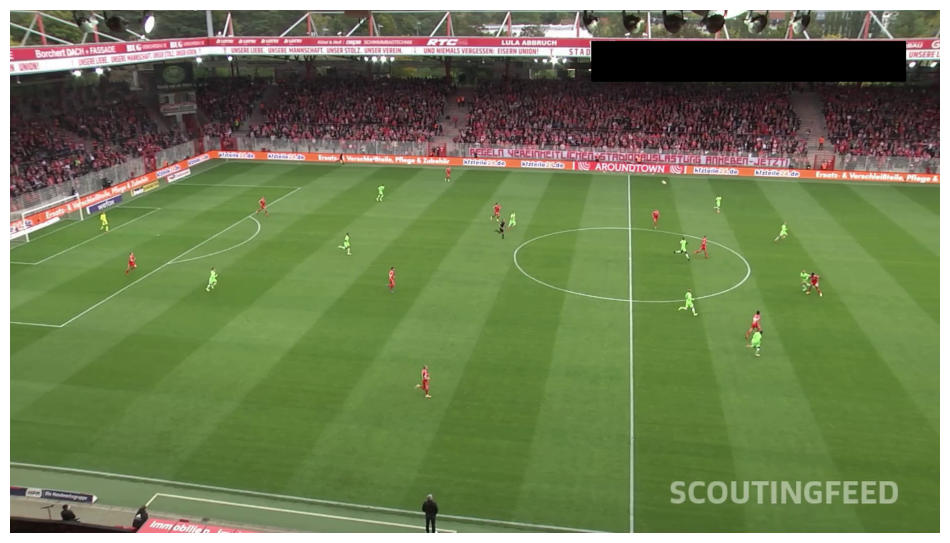

In [8]:
import supervision as sv

SOURCE_VIDEO_PATH = "/content/121364_0.mp4"

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

sv.plot_image(frame)

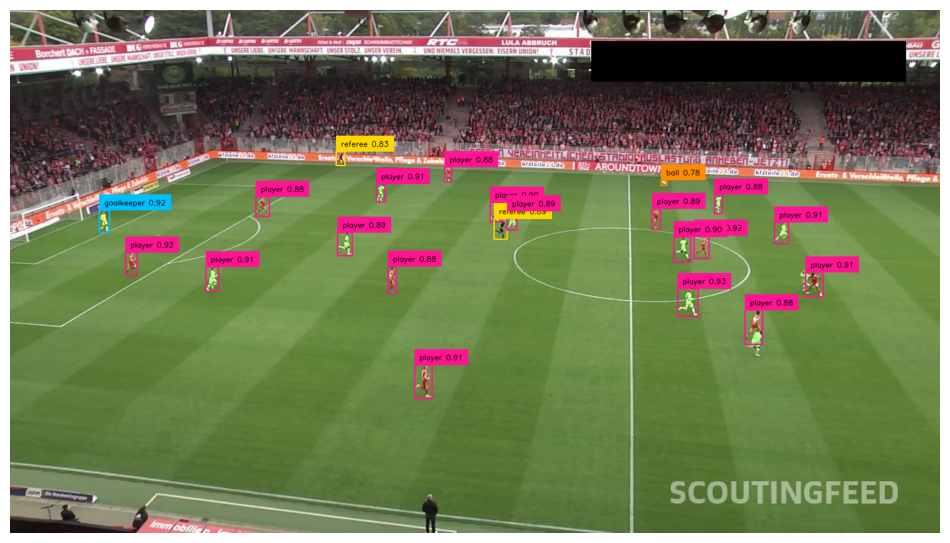

In [9]:
import supervision as sv

SOURCE_VIDEO_PATH = "/content/121364_0.mp4"

box_annotator = sv.BoxAnnotator(
    color=sv.ColorPalette.from_hex(['#FF8C00', '#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#FF8C00', '#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000')
)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
detections = sv.Detections.from_inference(result)

labels = [
    f"{class_name} {confidence:.2f}"
    for class_name, confidence
    in zip(detections['class_name'], detections.confidence)
]

annotated_frame = frame.copy()
annotated_frame = box_annotator.annotate(
    scene=annotated_frame,
    detections=detections)
annotated_frame = label_annotator.annotate(
    scene=annotated_frame,
    detections=detections,
    labels=labels)

sv.plot_image(annotated_frame)

In [10]:
from IPython.display import Video

video_path = "/content/121364_0.mp4"

display(video)